In [16]:
import pandas as pd 
import numpy as np 
import re
from tqdm import tqdm 
import matplotlib.pyplot as plt

In [2]:
import torch
import transformers
from transformers import BertForSequenceClassification, XLMRobertaForSequenceClassification, AdamW, BertConfig, BertTokenizer, XLMRobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import re
from bs4 import BeautifulSoup

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/option-generation/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [4]:
!nvidia-smi

Tue Mar 28 15:45:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   34C    P0    41W / 300W |      3MiB / 32768MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [5]:
#alternate sentiment model 
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)
tokenizer.save_pretrained(MODEL)
model = model.to(device)
model.eval()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [6]:
def predict_sentiment(text):  
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    output = model(**encoded_input)
    scores = output[0][0].detach().cpu().numpy()
    scores = softmax(scores)
    score = 0
    for i in range(len(scores)):
        score += (i-1)*scores[i]
    return score

In [7]:
generations = pd.read_csv("../../Data/Study1/modified_generation_data.csv")

In [8]:
#quickly creating a sentiment dict and embedding dict 
sentiment_dict = {}
for response, group in tqdm(generations.groupby("response")):
    sentiment_dict[response] = predict_sentiment(response)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10627/10627 [01:27<00:00, 121.36it/s]


In [9]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-roberta-large-v1')

In [10]:
model.encode("hi")

array([ 0.01286206,  0.00522242, -0.00587674, ...,  0.0232309 ,
       -0.04293944,  0.00205475], dtype=float32)

In [11]:
import math 
from scipy import spatial 
# def dist(r1, r2):
#   r1 = np.array(r1)
#   r2 = np.array(r2)
#   return np.linalg.norm((r1 - r2), ord=2)
def dist(r1, r2):
    r1 = np.array(r1)
    r2 = np.array(r2)
    return spatial.distance.cosine(r1, r2)
# def dist(r1, r2):
#   r1 = np.array(r1)
#   r2 = np.array(r2)
#   return np.linalg.norm((r1 - r2), ord=1)

# **Total Semantic Exploration (adjusted) vs Average Sentiment**

In [12]:
#semantic exploration vs average sentiment
exploration = {}
individual_sentiment = {}
for id, group in tqdm(generations.groupby("id")):
  exploration[id] = 0
  individual_sentiment[id] = []
  len_responses = 0
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    for response, group3 in group2.groupby("response"):
      if not pd.isna(response):
        embeddings.append(model.encode(response))
        individual_sentiment[id].append(sentiment_dict[response])
    len_responses += len(embeddings)
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        exploration[id] += dist(embeddings[i], embeddings[j])
  exploration[id] /= len_responses

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [03:37<00:00,  1.10s/it]


In [13]:
#find average sentiment 
for id in individual_sentiment:
  individual_sentiment[id] = sum(individual_sentiment[id])/len(individual_sentiment[id])

In [14]:
x = []
y = []
for id in exploration:
    if individual_sentiment[id] < .3 and 0.3 < exploration[id] < 3.0 :
        x.append(individual_sentiment[id])
        y.append(exploration[id])

(array([ 1.,  4.,  9., 15., 25., 50., 40., 39.,  6.,  5.]),
 array([0.93759663, 1.03099132, 1.12438601, 1.21778071, 1.3111754 ,
        1.40457009, 1.49796478, 1.59135948, 1.68475417, 1.77814886,
        1.87154355]),
 <BarContainer object of 10 artists>)

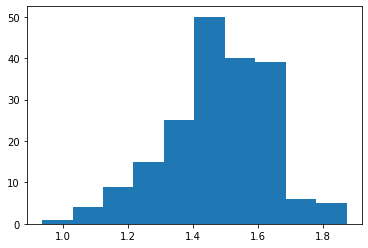

In [17]:
# plt.hist(x)
plt.hist(y)

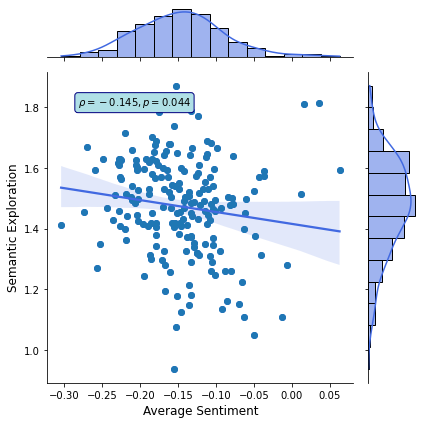

In [18]:
#display adjusted exploration vs average sentiment 
import seaborn as sns 
import scipy.stats as stats
import matplotlib.pyplot as plt

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Average Sentiment', ylabel='Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [19]:
#try to combine the above two plots 
import plotnine
from plotnine import ggplot, aes
# package for plot scales
from mizani.formatters import comma_format # (thousands seperator format)

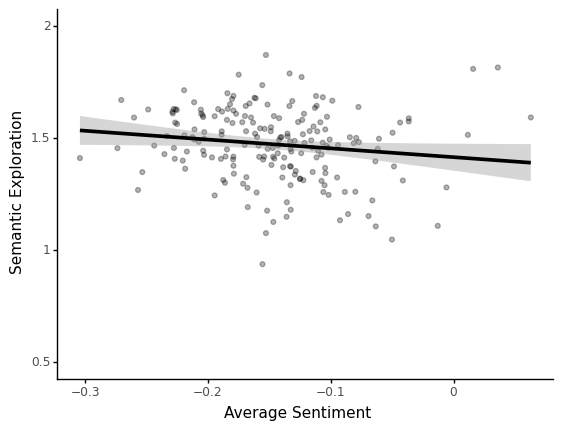

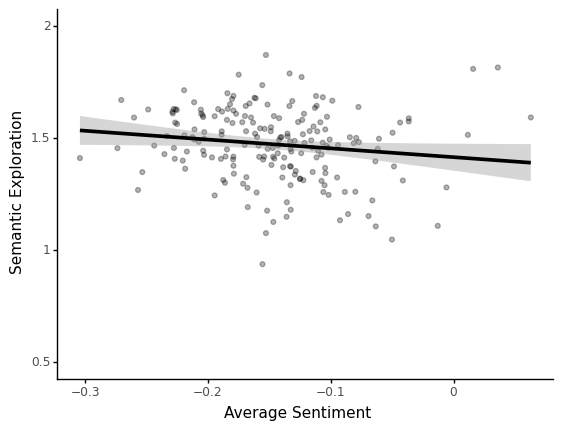

In [20]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Average_Sentiment", "Semantic_Exploration"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Average_Sentiment', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5) + 
 plotnine.xlab("Average Sentiment") +
 plotnine.ylab("Semantic Exploration") + 
 plotnine.coords.coord_cartesian(ylim=(0.5,2)) +
 plotnine.theme_classic()
).draw()




#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


In [21]:
def average_embedding(embeddings):
    df = pd.DataFrame(embeddings)
    df = df.mean(axis=0)
    return df.values.tolist()

# **Total Semantic Exploration vs Generation Number**

In [22]:
generations

Unnamed: 0  Unnamed: 0.1 vignette_name  generation_number  \
0               0             0         Erica                  1   
1               1             1         Erica                  2   
2               2             2         Erica                  3   
3               3             3         Erica                  4   
4               4             4         Erica                  5   
...           ...           ...           ...                ...   
12180       12180         12180       Cameron                  2   
12181       12181         12181       Cameron                  3   
12182       12182         12182       Cameron                  4   
12183       12183         12183       Cameron                  5   
12184       12184         12184       Cameron                  6   

       generation_time                                           response  \
0                    0                           break one of the windows   
1                    0                                    call the police   
2                    0                                alert mall security   
3                    0                            ask a stranger for help   
4                    0                                           call 911   
...                ...                                                ...   
12180                0                                       Tell her no.   
12181                0  Take her as far as you are going and drop her off   
12182                0                                         Call a cab   
12183                0                    Ask someone else at the station   
12184                0  Tell her you are going in the opposite direction.   

       reflection_score   id  
0                     0  196  
1                     0  196  
2                     0  196  
3                     0  196  
4                     0  196  
...                 ...  ...  
12180                 0  100  
12181                 0  100  
12182                 0  100  
12183                 0  100  
12184                 0  100  

[12185 rows x 8 columns]

In [23]:
# Real semantic exploration 
#exploration and answers tally average
exploration = {}
answers = {}
#exp and nums tally the individual explorations
exp = []
nums = []
for id, group in tqdm(generations.groupby("id")):
  for pnum, group2 in group.groupby("generation_number"):
    if pnum not in exploration: 
      exploration[pnum] = []
      # answers[pnum] = 0
    embeddings = []
    for response, group3 in group2.groupby("response"):
      response = group3['response'].to_list()[0]
      if not pd.isna(response):
        embeddings.append(model.encode(response).tolist())
    # answers[pnum] += len(embeddings)
    if len(embeddings) > 0:
      e = 0
      for i in range(len(embeddings)):
        for j in range(i+1, len(embeddings)):
          e += dist(embeddings[i], embeddings[j])
      exploration[pnum].append(e/len(embeddings))
      exp.append(e/len(embeddings))
      nums.append(pnum)

x_avg = []
y_avg = []
for num in exploration:
  x_avg.append(num)
  y_avg.append(sum(exploration[num])/len(exploration[num]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [03:12<00:00,  1.03it/s]


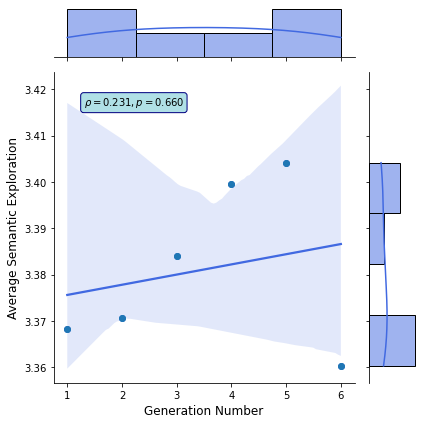

In [24]:
#plotting for stats
g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [25]:
d = pd.DataFrame(data=[nums,exp])
d = d.T
d.columns = ["Generation_Number", "Semantic_Exploration"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Semantic_Exploration"]

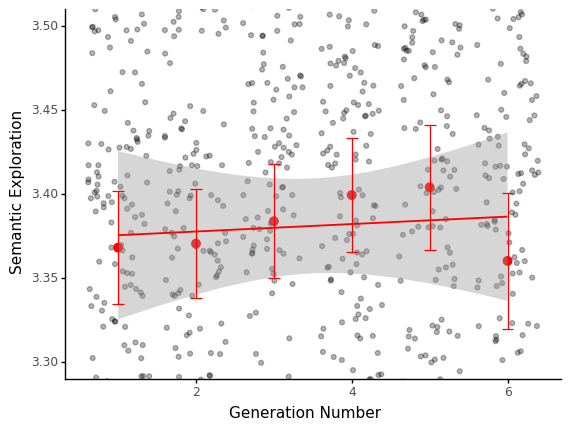

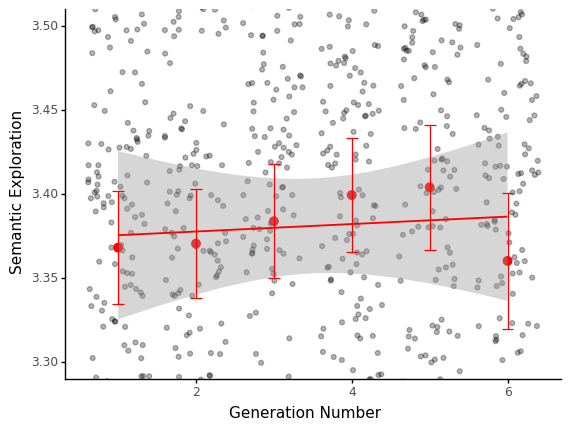

In [26]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Semantic_Exploration"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Semantic_Exploration-yerr",ymax="Semantic_Exploration+yerr"), color="red",width=.15) + 
 plotnine.ylab("Semantic Exploration") +
 plotnine.xlab("Generation Number") +
  plotnine.coords.coord_cartesian(ylim=(3.30, 3.50)) +
 plotnine.theme_classic()
  ).draw()

In [28]:
def total_variation(e):
    variation = 0
    count = 0
    for i in range(len(e)):
        for j in range(i+1, len(e)):
            variation += dist(e[i], e[j])
            count += 1
            if count%10000==0:
                print("done")
    return variation

# **Semantic Dissimilarity vs Generation Number**

In [29]:
# Semantic space similarity vs possibiltiy number (pairwise sim between all avg. embedding vectors)
vectordic = {}
for id, group in tqdm(generations.groupby("id")):
  for pnum, group2 in group.groupby("generation_number"):
    if pnum not in vectordic:
      vectordic[pnum] = []
    embeddings = []
    for generation in group2['response']:
      if not pd.isna(generation):
        embeddings.append(model.encode(generation))
    embeddings = pd.DataFrame(embeddings)
    embeddings = embeddings.mean(axis=0)
    embeddings = embeddings.values.tolist()
    if len(embeddings) > 0:
      vectordic.get(pnum).append(embeddings)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [03:32<00:00,  1.07s/it]


In [30]:
#semantic space dissimilarity vs generation nums
similarity = []
nums = []
avg_dic = {}
for num in tqdm(vectordic):
  avg_dic[num] = []
  for i in range(len(vectordic.get(num))):
    for j in range(i+1, len(vectordic.get(num))):
      nums.append(num)
      s = dist(vectordic.get(num)[i], vectordic.get(num)[j])
      similarity.append(s)
      avg_dic[num].append(s)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.67s/it]


In [31]:
# remove invalid data - why would the distance between two distinct localizing vectors be 0? 
x = nums
y = similarity
i = 0 
avg_dic = {}
while i < len(x):
  if y[i] == 0:
    y.pop(i)
    x.pop(i)
    i -= 1
  else:
    if x[i] not in avg_dic:
      avg_dic[x[i]] = []
    avg_dic[x[i]].append(y[i])
  i += 1
x_avg = []
y_avg = []
for num in avg_dic:
  avg_dic[num] = sum(avg_dic[num])/len(avg_dic[num])
  x_avg.append(num)
  y_avg.append(avg_dic[num])

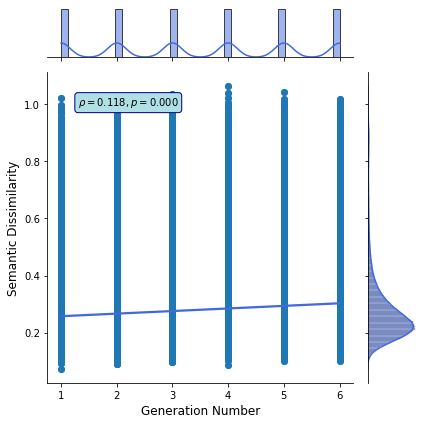

In [32]:
#plotting to find stats 
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

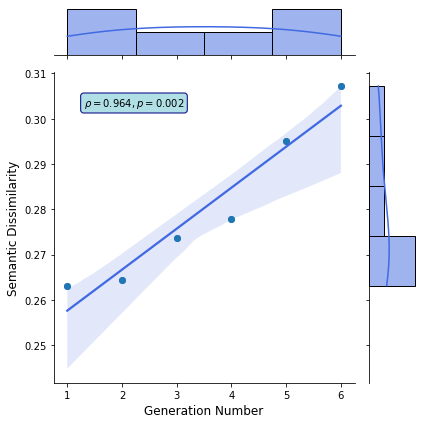

In [33]:
#plotting to find stats 

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

In [34]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Semantic_Dissimilarity"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Semantic_Dissimilarity"]

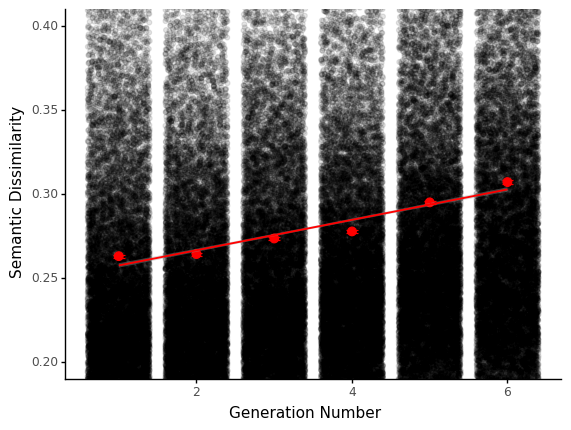

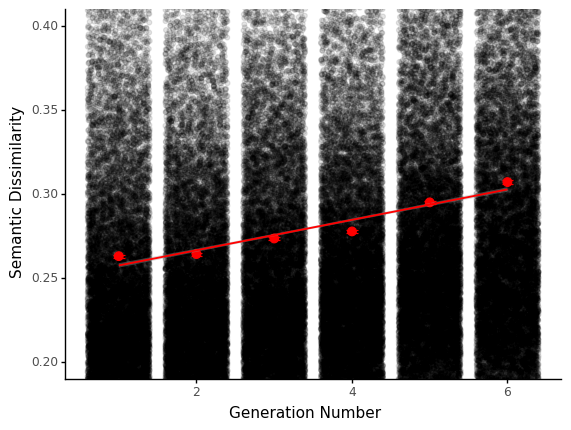

In [38]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Semantic_Dissimilarity"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Semantic_Dissimilarity'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.1) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Semantic_Dissimilarity-yerr",ymax="Semantic_Dissimilarity+yerr"), color="red",width=.15) + 
 plotnine.ylab("Semantic Dissimilarity") +
 plotnine.xlab("Generation Number") +
  plotnine.coords.coord_cartesian(ylim=(.2,.4)) +
 plotnine.theme_classic()
  ).draw()

# **Subjective Goodness vs Generation Number**
- No subjective ratings in this dataset

In [41]:
# #average goodness rating per possibility 
# scores = [[] for i in range(6)]
# nums = [i for i in range(6)]

# #all of the ratings 
# s = []
# n = []

# for pnum, group1 in generations.groupby("generation_number"):
#   for score in group1['reflection_score']:
#     scores[pnum-1].append(score)
#     s.append(score)
#     n.append(pnum)

# for i in range(len(scores)):
#   scores[i] = sum(scores[i])/len(scores[i])

In [42]:
# #plotting for stats
# x_avg = np.array(nums) 
# y_avg = np.array(scores)

# g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# # ax.annotate(stats.pearsonr)
# r, p = stats.pearsonr(x_avg, y_avg)
# g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
#                     xy=(0.1, 0.9), xycoords='axes fraction',
#                     ha='left', va='center',
#                     bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
# g.ax_joint.scatter(x_avg, y_avg)
# g.set_axis_labels(xlabel='Generation Number', ylabel='Subjective Rationality', size=12)
# plt.tight_layout()
# plt.show()

In [43]:
# d = pd.DataFrame(data=[n,s])
# d = d.T
# d.columns = ["Generation_Number", "Generation_Goodness"]

# d2 = pd.DataFrame(data=[x_avg,y_avg])
# d2 = d2.T
# d2.columns = ["Generation_Number", "Generation_Goodness"]

# errors = []
# for num, group in d.groupby("Generation_Number"):
#   errors.append(group.std()["Generation_Goodness"]/(len(group["Generation_Goodness"])**.5))
# d2["yerr"] = errors


In [44]:
# scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Generation_Goodness'))
# # add layers
# (scatter + 
#  plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
#  plotnine.geom_point(data=d2, color="red", size=3) +
#  plotnine.geom_smooth(method="lm",size=.75, color="red") + 
#  plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Goodness-yerr",ymax="Generation_Goodness+yerr"), color="red",width=.15) + 
#  plotnine.ylab("Subjective Rationality") +
#  plotnine.xlab("Generation Number") + 
#  plotnine.theme_classic()  +
#  plotnine.coords.coord_cartesian(ylim=(35,80)) 
#  ).draw()

# **Generation Sentiment vs Generation Number**

In [45]:
#generation sentiment vs generation number

sentiment = []
nums = []
avg_sentiment = {}
for id, participant in tqdm(generations.groupby('id')):
  for pos_num, group in participant.groupby('generation_number'):
    if pos_num not in avg_sentiment:
      avg_sentiment[pos_num] = []
    for generation in group['response']:
      if not pd.isna(generation):
        s = sentiment_dict[generation]
        sentiment.append(s)
        nums.append(pos_num)
        avg_sentiment[pos_num].append(s)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 775.45it/s]


In [46]:
x = nums
y = sentiment

x_avg = []
y_avg = []
for num in avg_sentiment:
  x_avg.append(num)
  y_avg.append(sum(avg_sentiment[num])/len(avg_sentiment[num]))

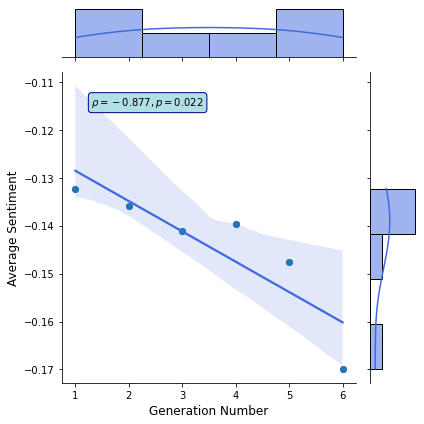

In [47]:
#plotting for stats 
g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Sentiment', size=12)
plt.tight_layout()
plt.show()

In [48]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Generation_Sentiment"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Sentiment"]

errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Sentiment"]/(len(group["Generation_Sentiment"])**.5))
d2["yerr"] = errors


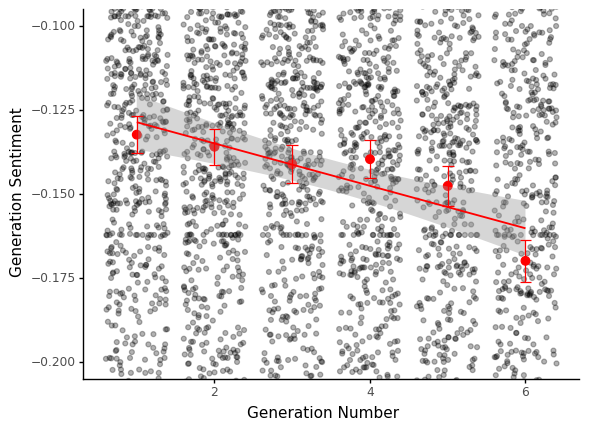

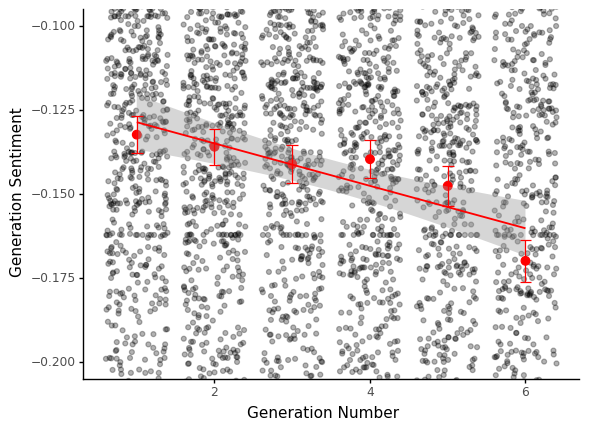

In [51]:
scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Generation_Sentiment'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Sentiment-yerr",ymax="Generation_Sentiment+yerr"), color="red",width=.15) + 
 plotnine.ylab("Generation Sentiment") +
 plotnine.xlab("Generation Number") + 
 plotnine.theme_classic() +
 plotnine.coords.coord_cartesian(ylim=(-.2,-.1)) 
).draw()

# **Generation Concreteness vs Generation Number**

In [52]:
concreteness = pd.read_csv("../../Data/Misc/Concreteness_ratings_Brysbaert_et_al_BRM.csv")

In [53]:
#create concreteness dict
concreteness_dict = {}
for word, group in concreteness.groupby("Word"):
  rating = group["Conc.M"].values[0]
  concreteness_dict[word] = rating

In [54]:
#figure out if later generations are more or less concrete 
import string 

conc = []
nums = []
cdic = {}
for id, group in generations.groupby("id"):
  for vign, group2 in group.groupby("vignette_name"):
    for num, group3 in group2.groupby("generation_number"):
      for response, group4 in group3.groupby("response"):
        if not pd.isna(response):
          response = response.translate(str.maketrans('', '', string.punctuation))
          score = []
          l = len(response.split(" "))
          for word in response.split(" "):
            if word in concreteness_dict:
              score.append(concreteness_dict[word])
          if len(score) > 0:
            score = sum(score)/len(score)
            # score = (sum(score)/len(score))/l
            conc.append(score)
            nums.append(num)
            if num not in cdic:
              cdic[num] = []
            cdic[num].append(score)

In [55]:
#find averages in concreteness differences
x_avg = []
y_avg = [] 
for key in cdic:
  cdic[key] = sum(cdic[key])/len(cdic[key])
  x_avg.append(key)
  y_avg.append(cdic[key])

print(cdic)

{1: 2.7781747754182877, 2: 2.756175477972731, 3: 2.718861656579942, 4: 2.7362795581628543, 5: 2.7175002959474055, 6: 2.7044433163211017}


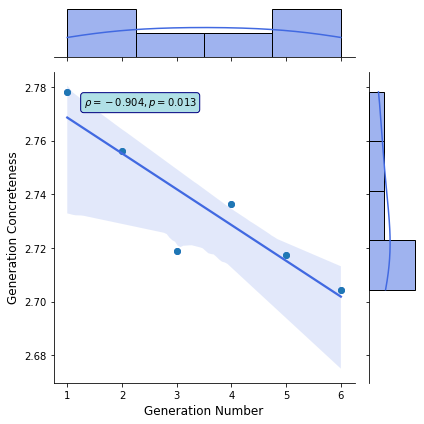

In [56]:
#just for stats

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Generation Concreteness', size=12)
plt.tight_layout()
plt.show()

In [57]:
d = pd.DataFrame(data=[nums,conc])
d = d.T
d.columns = ["Generation_Number", "Generation_Concreteness"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Concreteness"]

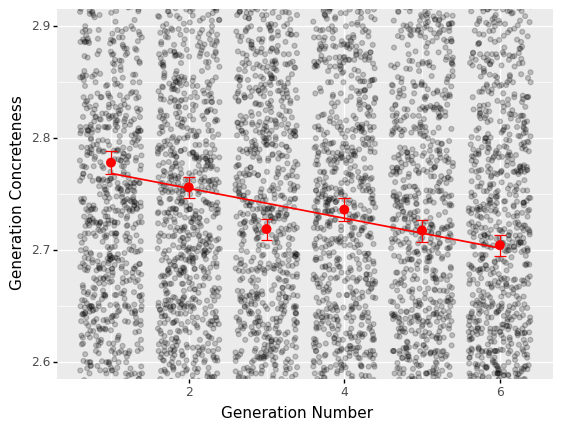

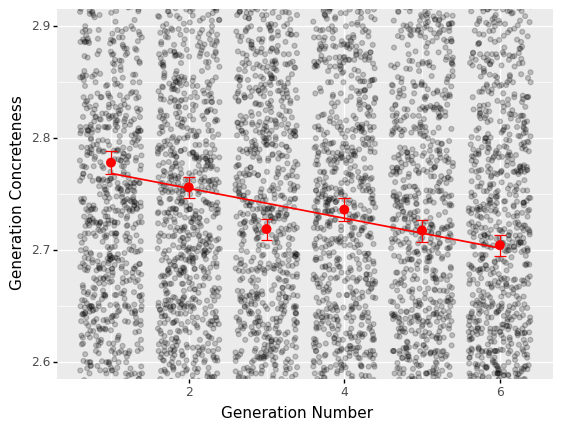

In [58]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Concreteness"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d2, mapping=aes(x='Generation_Number', y='Generation_Concreteness', ymin=2.7))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.2) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.70, color="red", se=False) + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Concreteness-yerr",ymax="Generation_Concreteness+yerr"), color="red",width=.15) + 
 plotnine.ylab("Generation Concreteness") +
 plotnine.xlab("Generation Number") + 
  plotnine.coords.coord_cartesian(ylim=(2.6,2.9))
  ).draw()

# **Concreteness vs Semantic Relatedness**

In [59]:
#bin the generations based on concreteness 
gens = {}
for response, group in generations.groupby("response"):
    response = response.translate(str.maketrans('', '', string.punctuation))
    score = []
    l = len(response.split(" "))
    for word in response.split(" "):
      if word in concreteness_dict:
        score.append(concreteness_dict[word])
    if len(score) > 0:
      score = sum(score)/len(score)
      gens[response] = score

In [60]:
#bin all of the responses : num bins = 10 
gens = dict(sorted(gens.items(), key=lambda item: item[1]))
len(gens)

10385

In [61]:
nbins = 100
bins = [[] for j in range(nbins)]
i = 0 
for item in gens:
  if i//int(len(gens)/nbins) < nbins:
    bins[i//int(len(gens)/nbins)].append((item, gens[item]))
  i += 1

In [62]:
from tqdm import tqdm

In [63]:
similarity = {}
for b in tqdm(range(len(bins))):
  if b not in similarity: 
    similarity[b] = []
  bin = bins[b]
  embeddings = {}
  for response in bin:
    response = response[0]
    embeddings[response] = model.encode(response)
  for i in range(len(bin)):
    for j in range(i+1, len(bin)):
      similarity[b].append(dist(embeddings[bin[i][0]], embeddings[bin[j][0]]))
  print(b)
similarity 


  1%|█▋                                                                                                                                                                     | 1/100 [00:01<03:07,  1.89s/it]

0


  2%|███▎                                                                                                                                                                   | 2/100 [00:03<02:59,  1.83s/it]

1


  3%|█████                                                                                                                                                                  | 3/100 [00:05<02:56,  1.82s/it]

2


  4%|██████▋                                                                                                                                                                | 4/100 [00:07<02:54,  1.82s/it]

3


  5%|████████▎                                                                                                                                                              | 5/100 [00:09<02:51,  1.81s/it]

4


  6%|██████████                                                                                                                                                             | 6/100 [00:10<02:49,  1.80s/it]

5


  7%|███████████▋                                                                                                                                                           | 7/100 [00:12<02:47,  1.80s/it]

6


  8%|█████████████▎                                                                                                                                                         | 8/100 [00:14<02:45,  1.80s/it]

7


  9%|███████████████                                                                                                                                                        | 9/100 [00:16<02:43,  1.79s/it]

8


 10%|████████████████▌                                                                                                                                                     | 10/100 [00:18<02:41,  1.80s/it]

9


 11%|██████████████████▎                                                                                                                                                   | 11/100 [00:19<02:39,  1.79s/it]

10


 12%|███████████████████▉                                                                                                                                                  | 12/100 [00:21<02:39,  1.81s/it]

11


 13%|█████████████████████▌                                                                                                                                                | 13/100 [00:23<02:37,  1.81s/it]

12


 14%|███████████████████████▏                                                                                                                                              | 14/100 [00:25<02:35,  1.80s/it]

13


 15%|████████████████████████▉                                                                                                                                             | 15/100 [00:27<02:33,  1.80s/it]

14


 16%|██████████████████████████▌                                                                                                                                           | 16/100 [00:28<02:31,  1.80s/it]

15


 17%|████████████████████████████▏                                                                                                                                         | 17/100 [00:30<02:29,  1.81s/it]

16


 18%|█████████████████████████████▉                                                                                                                                        | 18/100 [00:32<02:29,  1.82s/it]

17


 19%|███████████████████████████████▌                                                                                                                                      | 19/100 [00:34<02:27,  1.82s/it]

18


 20%|█████████████████████████████████▏                                                                                                                                    | 20/100 [00:36<02:25,  1.81s/it]

19


 21%|██████████████████████████████████▊                                                                                                                                   | 21/100 [00:38<02:24,  1.82s/it]

20


 22%|████████████████████████████████████▌                                                                                                                                 | 22/100 [00:39<02:23,  1.84s/it]

21


 23%|██████████████████████████████████████▏                                                                                                                               | 23/100 [00:41<02:23,  1.86s/it]

22


 24%|███████████████████████████████████████▊                                                                                                                              | 24/100 [00:43<02:20,  1.85s/it]

23


 25%|█████████████████████████████████████████▌                                                                                                                            | 25/100 [00:45<02:17,  1.84s/it]

24


 26%|███████████████████████████████████████████▏                                                                                                                          | 26/100 [00:47<02:15,  1.83s/it]

25


 27%|████████████████████████████████████████████▊                                                                                                                         | 27/100 [00:49<02:12,  1.82s/it]

26


 28%|██████████████████████████████████████████████▍                                                                                                                       | 28/100 [00:50<02:10,  1.82s/it]

27


 29%|████████████████████████████████████████████████▏                                                                                                                     | 29/100 [00:52<02:08,  1.81s/it]

28


 30%|█████████████████████████████████████████████████▊                                                                                                                    | 30/100 [00:54<02:06,  1.81s/it]

29


 31%|███████████████████████████████████████████████████▍                                                                                                                  | 31/100 [00:56<02:04,  1.81s/it]

30


 32%|█████████████████████████████████████████████████████                                                                                                                 | 32/100 [00:58<02:03,  1.81s/it]

31


 33%|██████████████████████████████████████████████████████▊                                                                                                               | 33/100 [00:59<02:01,  1.81s/it]

32


 34%|████████████████████████████████████████████████████████▍                                                                                                             | 34/100 [01:01<02:00,  1.82s/it]

33


 35%|██████████████████████████████████████████████████████████                                                                                                            | 35/100 [01:03<01:58,  1.82s/it]

34


 36%|███████████████████████████████████████████████████████████▊                                                                                                          | 36/100 [01:05<01:55,  1.81s/it]

35


 37%|█████████████████████████████████████████████████████████████▍                                                                                                        | 37/100 [01:07<01:53,  1.81s/it]

36


 38%|███████████████████████████████████████████████████████████████                                                                                                       | 38/100 [01:08<01:51,  1.81s/it]

37


 39%|████████████████████████████████████████████████████████████████▋                                                                                                     | 39/100 [01:10<01:50,  1.82s/it]

38


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 40/100 [01:12<01:48,  1.81s/it]

39


 41%|████████████████████████████████████████████████████████████████████                                                                                                  | 41/100 [01:14<01:47,  1.82s/it]

40


 42%|█████████████████████████████████████████████████████████████████████▋                                                                                                | 42/100 [01:16<01:45,  1.81s/it]

41


 43%|███████████████████████████████████████████████████████████████████████▍                                                                                              | 43/100 [01:18<01:43,  1.81s/it]

42


 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 44/100 [01:19<01:41,  1.81s/it]

43


 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                           | 45/100 [01:21<01:39,  1.81s/it]

44


 46%|████████████████████████████████████████████████████████████████████████████▎                                                                                         | 46/100 [01:23<01:38,  1.83s/it]

45


 47%|██████████████████████████████████████████████████████████████████████████████                                                                                        | 47/100 [01:25<01:36,  1.82s/it]

46


 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 48/100 [01:27<01:34,  1.81s/it]

47


 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 49/100 [01:28<01:32,  1.82s/it]

48


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 50/100 [01:30<01:30,  1.82s/it]

49


 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 51/100 [01:32<01:28,  1.81s/it]

50


 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 52/100 [01:34<01:26,  1.81s/it]

51


 53%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 53/100 [01:36<01:24,  1.80s/it]

52


 54%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 54/100 [01:38<01:23,  1.82s/it]

53


 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 55/100 [01:39<01:22,  1.83s/it]

54


 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 56/100 [01:41<01:23,  1.90s/it]

55


 57%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 57/100 [01:43<01:21,  1.89s/it]

56


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 58/100 [01:45<01:19,  1.90s/it]

57


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 59/100 [01:47<01:16,  1.88s/it]

58


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 60/100 [01:49<01:14,  1.85s/it]

59


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 61/100 [01:51<01:12,  1.85s/it]

60


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 62/100 [01:53<01:10,  1.85s/it]

61


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 63/100 [01:54<01:08,  1.84s/it]

62


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 64/100 [01:56<01:05,  1.83s/it]

63


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 65/100 [01:58<01:03,  1.82s/it]

64


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 66/100 [02:00<01:01,  1.81s/it]

65


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 67/100 [02:02<01:00,  1.83s/it]

66


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 68/100 [02:03<00:58,  1.82s/it]

67


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 69/100 [02:05<00:57,  1.85s/it]

68


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 70/100 [02:07<00:54,  1.83s/it]

69


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 71/100 [02:09<00:52,  1.82s/it]

70


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 72/100 [02:11<00:51,  1.82s/it]

71


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 73/100 [02:13<00:49,  1.82s/it]

72


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 74/100 [02:14<00:47,  1.82s/it]

73


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 75/100 [02:16<00:45,  1.83s/it]

74


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 76/100 [02:18<00:43,  1.82s/it]

75


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 77/100 [02:20<00:41,  1.81s/it]

76


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 78/100 [02:22<00:40,  1.83s/it]

77


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 79/100 [02:23<00:38,  1.81s/it]

78


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 80/100 [02:25<00:36,  1.81s/it]

79


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 81/100 [02:27<00:34,  1.80s/it]

80


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 82/100 [02:29<00:32,  1.80s/it]

81


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 83/100 [02:31<00:30,  1.80s/it]

82


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 84/100 [02:32<00:28,  1.79s/it]

83


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 85/100 [02:34<00:26,  1.79s/it]

84


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 86/100 [02:36<00:25,  1.79s/it]

85


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 87/100 [02:38<00:23,  1.79s/it]

86


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 88/100 [02:40<00:21,  1.81s/it]

87


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 89/100 [02:42<00:20,  1.85s/it]

88


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 90/100 [02:43<00:18,  1.84s/it]

89


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 91/100 [02:45<00:16,  1.83s/it]

90


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 92/100 [02:47<00:14,  1.81s/it]

91


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 93/100 [02:49<00:12,  1.81s/it]

92


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 94/100 [02:51<00:10,  1.81s/it]

93


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 95/100 [02:52<00:09,  1.80s/it]

94


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 96/100 [02:54<00:07,  1.80s/it]

95


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 97/100 [02:56<00:05,  1.79s/it]

96


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 98/100 [02:58<00:03,  1.79s/it]

97


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 99/100 [03:00<00:01,  1.79s/it]

98


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:01<00:00,  1.82s/it]

99


{0: [0.878592923283577,
  0.8984178453683853,
  0.8453292697668076,
  0.9795213006436825,
  0.8997305706143379,
  0.9010541588068008,
  0.9217608273029327,
  0.8616750240325928,
  1.0068414662964642,
  0.8525814265012741,
  0.9337845295667648,
  0.88255974650383,
  0.6935602426528931,
  0.9006439447402954,
  1.0143596725538373,
  0.9091703146696091,
  0.9468085318803787,
  1.0138265499845147,
  1.0172769855707884,
  1.0123236440122128,
  0.992779225576669,
  0.9887318722903728,
  0.8945334032177925,
  0.779893159866333,
  0.8928427547216415,
  0.8558860272169113,
  0.8581957072019577,
  0.9030195698142052,
  0.8910010382533073,
  1.0386218503117561,
  0.9177484437823296,
  0.6856911778450012,
  0.7912408709526062,
  0.8144618421792984,
  0.9463716112077236,
  0.82408607006073,
  0.8303490430116653,
  0.9787994045764208,
  0.847630113363266,
  0.9383724629878998,
  0.9501078389585018,
  0.9861639868468046,
  0.9203106686472893,
  0.998079854878597,
  0.7884158343076706,
  0.751605138182

In [64]:
buckets = {}
for key in similarity:
  buckets[key] = sum(similarity[key])/len(similarity[key])

In [65]:
x_avg = []
y_avg = []

for key in buckets:
  x_avg.append(key)
  y_avg.append(buckets[key])

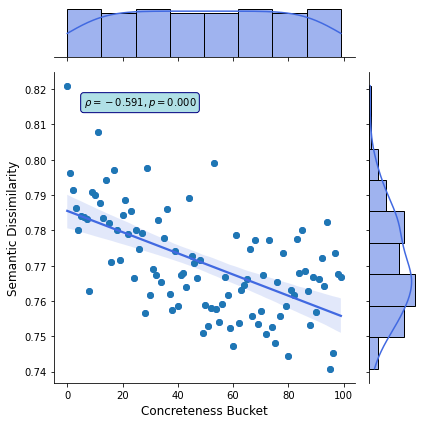

In [66]:
# to be clear, higher buckets have higher concreteness. 

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Concreteness Bucket', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

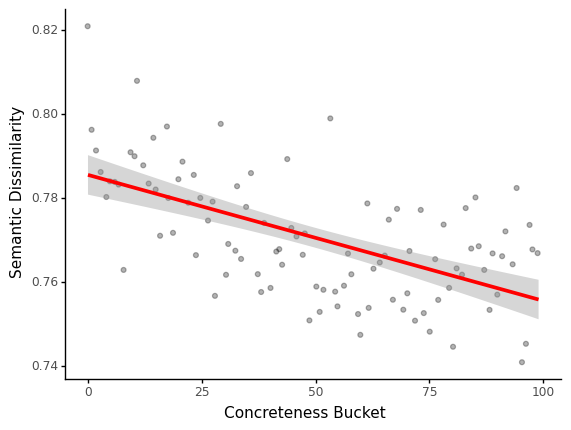

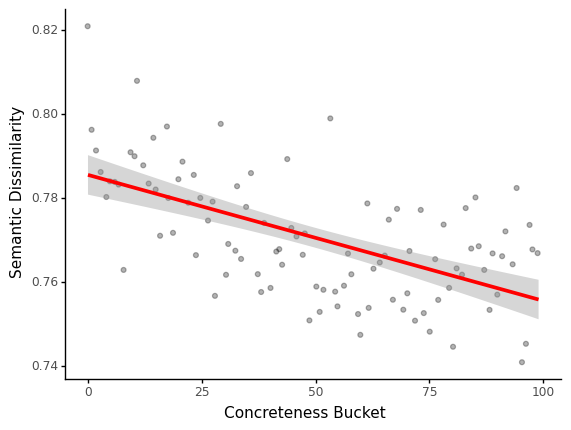

In [67]:
d = pd.DataFrame(data=[x_avg,y_avg])
d = d.T
d.columns = ["Concreteness_Bucket", "Semantic_Dissimilarity"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Concreteness_Bucket', y='Semantic_Dissimilarity'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Concreteness Bucket") +
 plotnine.ylab("Semantic Dissimilarity") + 
 plotnine.theme_classic()
).draw()

#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


# **Semantic Exploration vs Average Concreteness**

In [68]:
# semantic exploration 
exploration = {}
for id, group in tqdm(generations.groupby("id")):
  exploration[id] = 0
  len_responses = 0
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    for response, group3 in group2.groupby("response"):
      if not pd.isna(response):
        embeddings.append(model.encode(response))
    len_responses += len(embeddings)
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        exploration[id] += dist(embeddings[i], embeddings[j])
  exploration[id] /= len_responses

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [03:07<00:00,  1.05it/s]


In [69]:
#determine avg concreteness 
id_concreteness = {}
for id, group in tqdm(generations.groupby("id")):
  for response, group2 in group.groupby("response"):
    response = response.translate(str.maketrans('', '', string.punctuation))
    score = []
    l = len(response.split(" "))
    for word in response.split(" "):
      if word in concreteness_dict:
        score.append(concreteness_dict[word])
    if len(score) > 0:
      if id not in id_concreteness:
        id_concreteness[id] = []
      score = sum(score)/len(score)
      id_concreteness[id].append(score)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 679.07it/s]


In [70]:
for id in id_concreteness:
  id_concreteness[id] = sum(id_concreteness[id])/len(id_concreteness[id])

In [80]:
x = []
y = []
for id in id_concreteness:
    if id in exploration and exploration[id] < 3.0:
        x.append(id_concreteness[id])
        y.append(exploration[id])

(array([ 10.,  41., 108.,  34.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([0.93759663, 1.16534052, 1.3930844 , 1.62082829, 1.84857217,
        2.07631606, 2.30405995, 2.53180383, 2.75954772, 2.98729161,
        3.21503549]),
 <BarContainer object of 10 artists>)

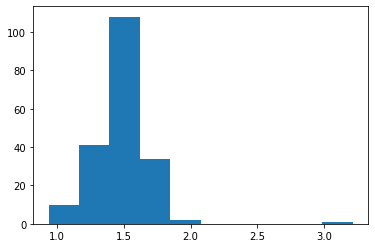

In [79]:
plt.hist(y)

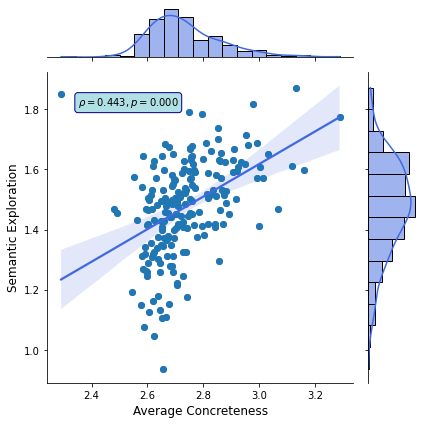

In [81]:
#display adjusted exploration vs average sentiment 
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Average Concreteness', ylabel='Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

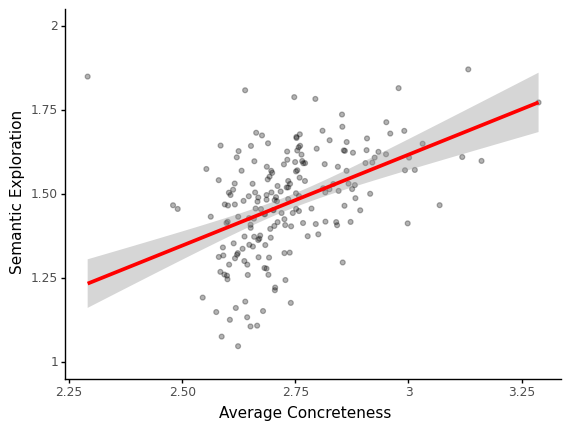

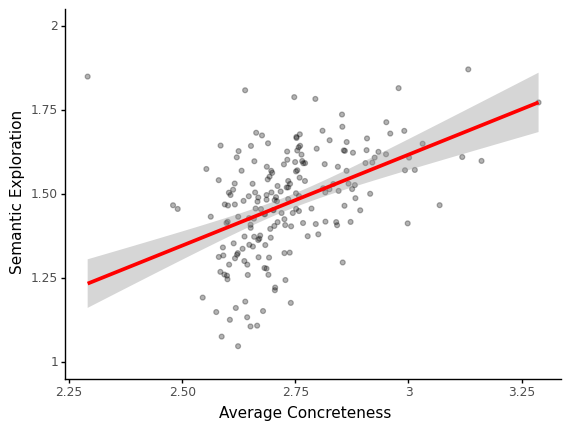

In [83]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Average_Concreteness", "Semantic_Exploration"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Average_Concreteness', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Average Concreteness") +
 plotnine.ylab("Semantic Exploration") + 
 plotnine.theme_classic() + 
 plotnine.coords.coord_cartesian(ylim=(1,2))
).draw()

#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


# **Generation Concreteness vs Subjective Score**
- Again, no subjective rating in this dataset

In [87]:
# concreteness = []
# subjective = []
# for response, group in tqdm(generations.groupby("response")):
#   response = response.translate(str.maketrans('', '', string.punctuation))
#   score = []
#   l = len(response.split(" "))
#   for word in response.split(" "):
#     if word in concreteness_dict:
#       score.append(concreteness_dict[word])
#   if len(score) > 0 :
#     score = sum(score)/len(score)
#     concreteness.append(score)
#     subjective.append(list(group["reflection_score"])[0])


In [86]:
# x = concreteness
# y = subjective

# g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# # ax.annotate(stats.pearsonr)
# r, p = stats.pearsonr(x, y)
# g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
#                     xy=(0.1, 0.9), xycoords='axes fraction',
#                     ha='left', va='center',
#                     bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
# g.ax_joint.scatter(x, y)
# g.set_axis_labels(xlabel='Concreteness', ylabel='Subjective Score', size=12)
# plt.tight_layout()
# plt.show()

# **Generation Concreteness vs Generation Sentiment**

In [88]:
concreteness = []
sentiment = []
for response, group in tqdm(generations.groupby("response")):
  words = response.translate(str.maketrans('', '', string.punctuation))
  score = []
  l = len(words.split(" "))
  for word in words.split(" "):
    if word in concreteness_dict:
      score.append(concreteness_dict[word])
  if len(score) > 0:
    score = sum(score)/len(score)
    concreteness.append(score)
    sentiment.append(sentiment_dict[response])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10627/10627 [00:00<00:00, 67163.52it/s]


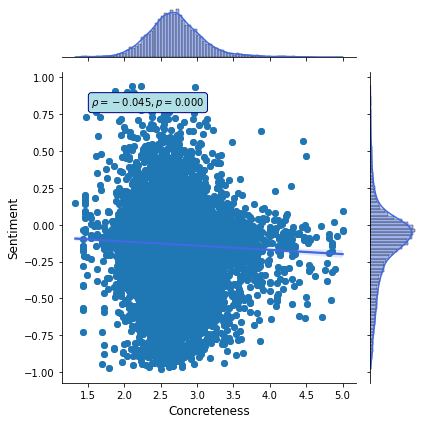

In [89]:
x = concreteness
y = sentiment

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Concreteness', ylabel='Sentiment', size=12)
plt.tight_layout()
plt.show()